<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Monday 08 July 2019</td>
<td style="text-align: right;"><a href="https://github.com/douglask3/amazon_fires/tree/EGU2020">github.com/douglask3/amazon_fires/tree/EGU2020</td>
</tr>
</table>
<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity of a global fire limitation model using Bayesian inference</h1>
<h2>Part 3: Posterior sampling</h2>
<br>
<br>
<sup>1,* </sup> Douglas Ian Kelley,
<sup>2 </sup>Chantelle Burton, 
<sup>3 </sup>Rhys Whitley,
<sup>1 </sup>Chris Huntingford,
<sup>4 </sup>Ioannis Bistinas, 
<sup>1,5 </sup>Megan Brown, 
<sup>6 </sup>Ning Dong, 
<sup>1 </sup>Toby R. Marthews
<br>
<br>
<br>
<sup>*  </sup> douglas.i.kelley@gmail.com
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Met Office United Kingdom, Exeter, United Kingdom
<br>
<sup>3 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<sup>4 </sup>ATOS Nederland B.V., Amstelveen, The Netherlands
<br>
<sup>5 </sup>School of Physical Sciences, The Open University, Milton Keynes, UK
<br>
<sup>6 </sup>Department of Biological Sciences, Macquarie University, North Ryde, NSW 2109, Australia 
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
The previous notebook quantified the probability distribution of the model parameters of our global fire model. Here, we sample this distribution to obtain a number of key measures of fire regime: burnt area, and the limitation and sensitivity of fuel, moisture, ignitions and suppression controls.
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

# Load libraries

In [1]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
from   libs.plot_maps    import *
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import lognorm


def npLogit(x):
    return np.log(x/(1.0-x))

# We're using the row which has minimum sigma
def newCubes3D(variable, step, eg_cube_in, dimname = 'model_level_number', minV = -10, maxV = None):
    
    
    #maxV = np.max(eg_cube_in.data)    
    #maxV = np.min([1.0, np.ceil(maxV) * 1.5])
    
    def newCube(i):
        coord = iris.coords.AuxCoord(i, dimname)
        eg_cube = eg_cube_in.copy()
        eg_cube.data[eg_cube.data > 0.0] = 0.0
        try:
            eg_cube.remove_coord(dimname)
        except:
            pass
        eg_cube.add_aux_coord(coord)
        return(eg_cube)
    
    if not hasattr(step, '__len__'):
        
        if minV is None: minV = np.round(npLogit(np.min(eg_cube_in.data[eg_cube_in.data>0.0]))) #* 2.0
        if maxV is None: maxV = -minV#np.round(npLogit(np.max(eg_cube_in.data[eg_cube_in.data<1.0])))
        
        minV = minV - 1
        step = np.arange(minV ,maxV, step)     
    
    eg_cubes = iris.cube.CubeList([newCube(i) for i in step])
    eg_cubes = eg_cubes.merge()[0]
    
    return(eg_cubes)


## Input information

Modify 'title_output' and you'll also need to mannually mkdir of the title_output in respective 'figures' folder. You can change which input are used to put into the model by changing the file dictionaries.
JULES data only runs from July 2000 to Dec 2010, so I created a separate dictionary for that (below). If you use this, you'll also have to change the output and figure directory.


Data in 'retrieved_codes/2000-2014' and 'jul2000-2014' has already been scaled and adjusted (e.g. lightning, RH).
The jul2000-2014 files have 168 time points and start at July 2000 and go up to June 2014, like the obs files. This makes them compatible when mixing up obs + UKESM runs.

In [2]:
dir = "../data/ISIMIP_data2/"
model_names = os.listdir(dir)[0:4]
experiments = os.listdir(dir + model_names[0])


files = {'soilwMax'           : 'soil12.nc',
         'shallow_soilw'      : 'soilM_top.nc',
         'deep_soilw'         : 'soilM_bottom.nc',
         'precip'             : 'precip.nc',
         'emc'                : 'humid.nc',
         'treeCover'          : 'trees.nc',
         'pasture'            : 'pas.nc',
         'cropland'           : 'crop.nc',
         'vegcover'           : 'totalVeg.nc',
         'burnt_area'         : '../../burnt_area_GFED4sObs.nc'}


In [3]:
param_file = '../outputs/params-for_sampling/'
title_output = 'attempt3-full'

Open data. The model takes data in the same dict class as above.

In [4]:
##open data
def loadInputsParams(model, experiment):
    print(model)
    print(experiment)
    input_data = {}
    for key, file in files.items():
        data = iris.load_cube(dir + model + '/' + experiment + '/' + file)
        input_data[key] = data

    params = pd.read_csv(param_file + model + '.csv')
    return input_data, params
    
inputs = [[loadInputsParams(model, experiment) for experiment in experiments] for model in model_names]

HADGEM2-ES
historic
HADGEM2-ES
RCP2.6
HADGEM2-ES
RCP6.0
MIROC5
historic
MIROC5
RCP2.6
MIROC5
RCP6.0
GFDL-ESM2M
historic
GFDL-ESM2M
RCP2.6
GFDL-ESM2M
RCP6.0
IPSL-CM5A-LR
historic
IPSL-CM5A-LR
RCP2.6
IPSL-CM5A-LR
RCP6.0


Plotting annual averages just to make sure the data looks senible

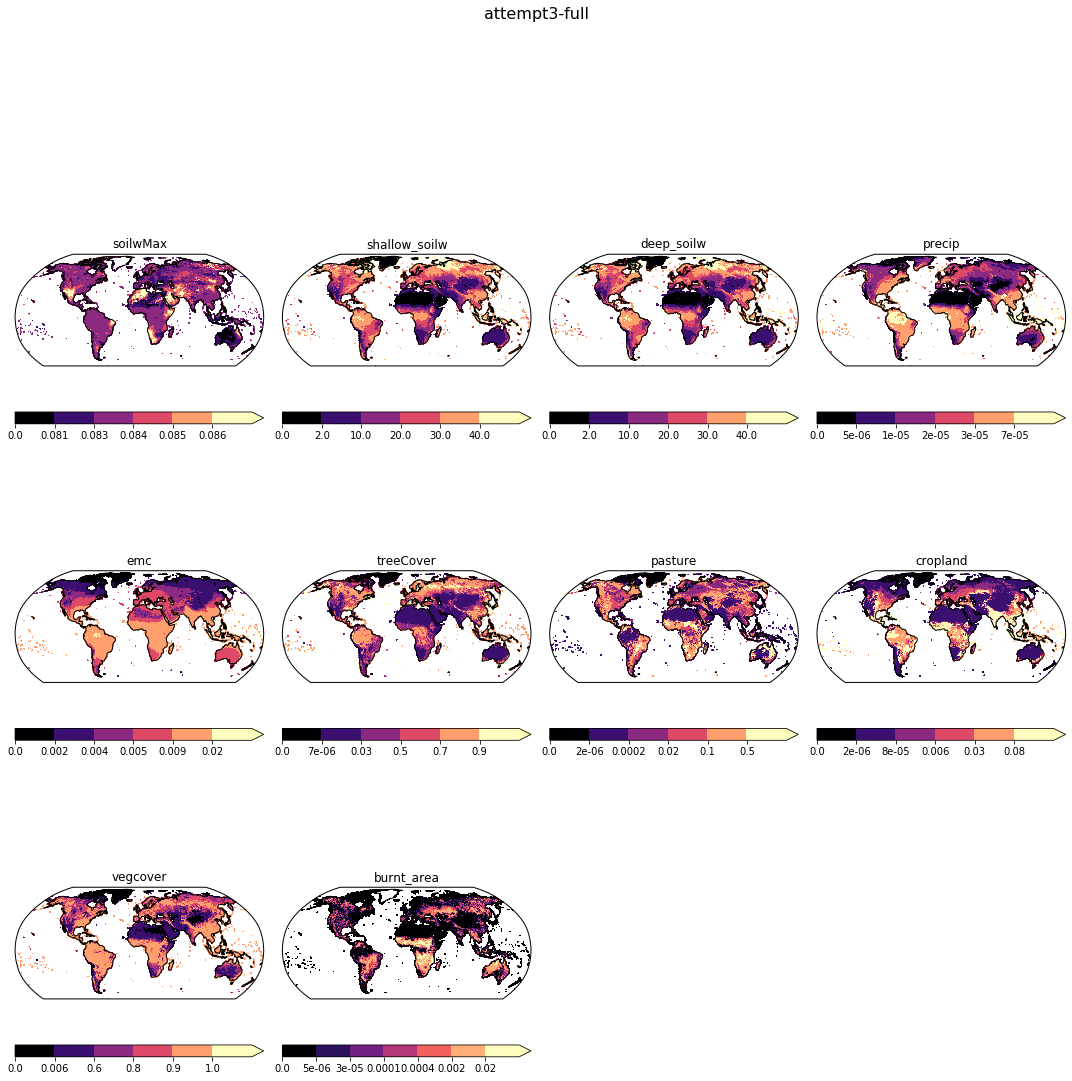

In [5]:
input_data = inputs[0][0][0]
nd = 0

plt.figure(figsize = (15, 20))

for key, dat in input_data.items():
    nd = nd + 1
    dat = dat.collapsed('time', iris.analysis.MEAN)
    dat.long_name = key
    plot_lonely_cube(dat, 4, 4, nd, cmap = 'magma', levels = None)
    plt.suptitle(title_output, fontsize=16)
    plt.subplots_adjust(top=0.88)


## The model
The model is defined Kelley et al. 2019 and Kelley et al. submitted (available soon). See those for full model equations. Below, we define the model, this time as a class object on gridded temporal data and using ```np``` rather than ```tt```. This could be moved into a library at some point, but I've defined it here so you can have a proper look.

The model calculates a number of things needed to predict burnt area, and a few metric (potential limitation and sensitivity) on the fly. The things needed to calculate burnt area are ``ConFIRE.``:

* **Controls**:
    * ``fuel``: fuel continuity
    * ``moisture``: fuel mositure content
    * ``ignitions``: potential ignitions
    * ``suppression``: human fire suppression and landscape fragmentation

* **Limitation from controls**, the maximum allowed fire considering limitation from:
    * ``standard_fuel``:  fuel
    * ``standard_moisture``:  moisture
    * ``standard_ignitions``:  ignitions
    * ``standard_suppression``:  suppression

* and ``burnt_area``: burnt area from all limitations

Things calculated on the fly are:

* **Potential limitation**, the increase in burnt area if limitation where removed from:
    * ``potential_fuel``:  fuel
    * ``potential_moisture``:  moisture
    * ``potential_ignitions``:  ignitions
    * ``potential_suppression``:  suppression

* **Sensitvity**, the rate of change in burnt area for a given control, relative to the maximum possible rate of change for that controls:
    * ``sensitivity_fuel``:  fuel
    * ``sensitivity_moisture``:  moisture
    * ``sensitivity_ignitions``:  ignitions
    * ``sensitivity_suppression``:  suppression

In [6]:
class ConFIRE(object):
    def __init__(self, data, params):
        """
        Initalise parameters and calculates the key variables needed to calculate burnt area.
        """
        self.params = params


        ## finds controls
        self.fuel = self.control_fuel(data['vegcover'], data['soilwMax'], self.params['fuel_pw'],
                                      self.params['fuel_pg'])
        
        self.emcw = self.emc_weighted(data['emc'], data["precip"], self.params['wd_pg'])
        
        self.moisture = self.control_moisture(data['shallow_soilw'], data['deep_soilw'],
                                              self.emcw, data['treeCover'],
                                              self.params['cMs'], self.params['cM'], self.params['cMT'], 
                                              self.params['kM'], self.params['pT'])

        self.ignitions = self.control_ignitions(data['pasture'])

        self.suppression = self.control_suppression(data['cropland'])

        ## calculates limiting factor of each control.
        self.standard_fuel        = self.sigmoid(self.fuel       ,
                                            self.params[       'fuel_x0'], self.params[       'fuel_k'])  
        
        self.standard_moisture    = self.sigmoid(self.moisture   ,
                                            self.params[   'moisture_x0'], -self.params[   'moisture_k'])
        self.standard_ignitions   = self.sigmoid(self.ignitions   ,
                                            self.params[  'ignition_x0'], self.params[  'ignition_k'])
        self.standard_suppression = self.sigmoid(self.suppression,
                                            self.params['suppression_x0'], -self.params['suppression_k'])
        
        
        self.error = self.params['sigma']
        ## burnt area us just limitation of each control muliplied together.
        self.burnt_area_mode = self.standard_fuel * self.standard_moisture * self.standard_ignitions * \
            self.standard_suppression * self.params['max_f']
        
        ## find the mean burnt area
        self.burnt_area_calPDF(data, self.params['p0'], self.params['pp'])
        
        self.burnt_area = self.burnt_area_mean.copy() #* (1.0-self.p0)
        
        #browser()
        
        self.standard_moisture    = self.standard_moisture    / self.sigmoid(0.0, self.params['moisture_x0'],
                                                 -self.params['moisture_k'])
        self.standard_suppression = self.standard_suppression / self.sigmoid(0.0, self.params['suppression_x0'],
                                                 -self.params['suppression_k'])

        self.potential_fuel = self.potential(self.standard_fuel, "potential_fuel")
        self.potential_moisture = self.potential(self.standard_moisture, "potential_moisture")
        self.potential_ignitions = self.potential(self.standard_ignitions, "potential_ignitions")
        self.potential_suppression = self.potential(self.standard_suppression, "potential_suppression")

        self.sensitivity_fuel = self.sensitivity(self.fuel, self.params['fuel_x0'], self.params['fuel_k'],
                                    self.standard_fuel, "sensitivity_fuel")

        self.sensitivity_moisture = self.sensitivity(self.moisture, self.params['moisture_x0'], -self.params['moisture_k'],
                                    self.standard_moisture, "sensitivity_moisture")

        self.sensitivity_ignitions = self.sensitivity(self.ignitions, self.params['ignition_x0'], self.params['ignition_k'],
                                    self.standard_ignitions, "sensitivity_ignitions")


        self.sensitivity_suppression = self.sensitivity(self.suppression, self.params['suppression_x0'], -self.params['suppression_k'] ,
                                    self.standard_suppression, "sensitivity_suppression")


        ## if the inputs are iris cubes, we can add some useful metadata
        try:
            self.burnt_area.long_name = "burnt_area"
            self.burnt_area_mode.long_name = "burnt_area_mode"
            #self.burnt_area_median.long_name = "burnt_area_median"
            self.burnt_area_mean.long_name = "burnt_area_mean"

            self.fuel.long_name = "fuel continuity"
            self.fuel.units = '1'

            self.moisture.long_name = "moisture content"
            self.moisture.units = '1'

            self.ignitions.long_name = "ignitions"
            self.ignitions.units = 'km-2'

            self.suppression.long_name = "suppression"
            self.suppression.units = '1'

            self.standard_fuel.long_name = "standard_fuel"
            self.standard_moisture.long_name = "standard_moisture"
            self.standard_ignitions.long_name = "standard_ignitions"
            self.standard_suppression.long_name = "standard_suppression"

            self.standard_fuel.units = '1'
            self.standard_moisture.units = '1'
            self.standard_ignitions.units = '1'
            self.standard_suppression.units = '1'
        except:
            pass        
    
        
    def control_fuel(self, vegcover, alphaMax, fuel_pw, fuel_pg):
        """
        Definition to describe fuel load: while return the input; capability to be modified later.
        """
        return (vegcover**(fuel_pw+1)) * (fuel_pg * (alphaMax-1) + 1) / (1 + fuel_pg)
    
    def emc_weighted(self, emc, precip, wd_pg):
        try:
            wet_days = 1 - np.exp(-wd_pg * precip)
            emcw = wet_days + (1-wet_days) * emc
        except:
            emcw = emc.copy()
            emcw.data  = 1 - np.exp(-wd_pg * precip.data)
            emcw.data = emcw.data + (1-emcw.data) * emc.data
        return(emcw)

    def control_moisture(self, shallow_soil, deeps_soil, emc, treeCover, cMs, cM, cMT, kM, pT):
        """
        Definition to describe moisture
        """
        moist = (shallow_soil/100.0 + cMs * deeps_soil/100.0 + cM*emc + cMT * (treeCover**pT)) / (1 + cMs + cM + cMT)
        moist.data = 1 - np.log(1 - moist.data*kM)
        return moist


    def control_ignitions(self,pasture):
        """
        Definition for the measure of ignition
        """
        return pasture


    def control_suppression(self, cropland):
        """
        Definition for the measure of fire supression
        """
        return cropland

        """
        Defines potential limitation for each control in turn
        """
   
    def sensitivity(self, x, x0, k, fi, long_name = None):

        gradient = self.gradient(x, x0, k)
        sens = gradient * self.control_removal(fi)

        try: sens.units = '1'
        except: pass

        if long_name is not None:
            try: sens.long_name = long_name
            except: browser()
        return sens


    def control_removal(self, fi):
        return self.burnt_area_mode/fi


    def potential(self, fi, long_name = None):
        out = fi.copy()
        out.data = self.burnt_area_mode.data * ((1/out.data) - 1)

        try: out.units = '1'
        except: pass

        if long_name is not None:
            try: out.long_name = long_name
            except: pass
        return out


    def gradient(self, x, x0, k, dx = 0.0001):

        f1 = self.sigmoid(x + dx, x0, k)
        f2 = self.sigmoid(x - dx, x0, k)

        n1 = self.sigmoid(x0 + dx, x0, k)
        n2 = self.sigmoid(x0 - dx, x0, k)

        try:
            f1 = (f1 - f2)/(n1 - n2)
        except:
            f1.data = (f1.data - f2.data) / (n1.data - n2.data)

        return f1


    def sigmoid(self, x, x0,k):
        """
        Sigmoid function to describe limitation using tensor
        """
        try:
            out = x.copy()
            out.data = -k*(x.data - x0)
            out.data = 1.0/(1.0 + np.exp(out.data))
            x = out
        except:
            x = -k * (x - x0)
            x = 1.0/(1.0 + np.exp(x))
        return x
    
    def burnt_area_calPDF(self, data, p0, pp):
        
        mask = np.logical_not(self.burnt_area_mode.data.mask)
        self.burnt_area_pdf = newCubes3D('burnt_area', 0.5, data['burnt_area'])
        
        self.burnt_area_mean = self.burnt_area_mode.copy()
        self.burnt_area_mean.data[mask] = 0.0
        
        level_no = self.burnt_area_pdf.coord('model_level_number').points
        
        dist = norm(npLogit(self.burnt_area_mode.data[mask]), self.error)
        
        self.pz = 1.0 - (self.burnt_area_mode.data[mask]**pp) * (1.0 - p0)
        
        self.burnt_area_pdf.data[0][mask] = self.pz 
        x = self.burnt_area_pdf.coord('model_level_number').points
        for k in range(1, self.burnt_area_pdf.shape[0]):       
            self.burnt_area_pdf.data[k][mask] = dist.pdf(x[k]) * (1.0 - self.pz)
            self.burnt_area_mean.data[mask]  = self.burnt_area_mean.data[mask] +  dist.pdf(x[k]) * (1.0 - self.pz)  *(1/(1+np.exp(-x[k])))
                                     
        PDFtot = self.burnt_area_pdf.collapsed(['model_level_number'], iris.analysis.SUM)
        
        self.burnt_area_mean.data = self.burnt_area_mean.data/ PDFtot.data
       
        
        

In [12]:
input_data = inputs[0][0][0].copy()
for key in input_data.keys(): input_data[key] = inputs[0][0][0][key][0]
inputs[0][0][0]["burnt_area"].shape


soilwMax
shallow_soilw
deep_soilw
precip
emc
treeCover
pasture
cropland
vegcover
burnt_area


In [8]:

def bootSamples(x, samples, nsample = 2):
    def bootSample(x):
        #browser()or np.ma.is_masked(test)
        test = np.ma.sum(x)
        
        out = np.repeat(0, nsample)
        if test==0 : return out
        try:
            out = np.random.choice(samples, nsample, p =x/np.sum(x))
        except:
            out = np.repeat(0, nsample)
        return out
    x = np.apply_along_axis(bootSample, 0, x)
    return(x)



In [9]:
def runModelExperiment(input, paramLoc = None):
    input_data = input[0].copy()
    params = input[1]
    if paramLoc is None: paramLoc = params["sigma"].idxmin()
    print("running")
    nmns = input[0]["precip"].shape[0]
    for mn in range(0, nmns):
        
        for key in input_data.keys():
            try:
                input_data[key] = input[0][key][mn]
            except:
                print(key)
                input_data[key] = input[0][key][mn-12]
        model = ConFIRE(input_data, params.loc[paramLoc])
        PDF = model.burnt_area_pdf.data
        if mn == 0:
            mask = PDF[0,:,:].mask == False
            BAs = model.burnt_area_pdf.coord("model_level_number").points
            BAs = 1/(1+np.exp(-BAs))
            BAs[0] = 0.0
            
        PDF = bootSamples(PDF[:,mask], BAs, 10)
        
        if mn == 0:
            model_out = model
            PDF_out = PDF
        else:
            model_out.burnt_area_mean.data += model.burnt_area_mean.data
            model_out.fuel.data += model.fuel.data
            model_out.moisture.data += model.moisture.data
            model_out.ignitions.data += model.ignitions.data
            model_out.suppression.data += model.suppression.data
            
            model_out.standard_fuel.data += model.standard_fuel.data 
            model_out.standard_moisture.data += model.standard_moisture.data 
            model_out.standard_ignitions.data += model.standard_ignitions.data 
            model_out.standard_suppression.data += model.standard_suppression.data 
            
            model_out.potential_fuel.data += model.potential_fuel.data 
            model_out.potential_moisture.data += model.potential_moisture.data 
            model_out.potential_ignitions.data += model.potential_ignitions.data 
            model_out.potential_suppression.data += model.potential_suppression.data 
            
            model_out.sensitivity_fuel.data += model.sensitivity_fuel.data 
            model_out.sensitivity_moisture .data += model.sensitivity_moisture.data 
            model_out.sensitivity_ignitions.data += model.sensitivity_ignitions.data 
            model_out.sensitivity_suppression.data += model.sensitivity_suppression.data 
            PDF_out += PDF
        #browser()
    nyrs = nmns / 12
    model_out.burnt_area_mean.data /= nyrs
    
    model_out.fuel.data /= nmns
    model_out.moisture.data /= nmns
    model_out.ignitions.data /= nyrs
    model_out.suppression.data /= nmns 
            
    model_out.standard_fuel.data /= nmns
    model_out.standard_moisture.data /= nmns
    model_out.standard_ignitions.data /= nmns
    model_out.standard_suppression.data /= nmns
            
    model_out.potential_fuel.data /= nyrs
    model_out.potential_moisture.data /= nyrs
    model_out.potential_ignitions.data /= nyrs
    model_out.potential_suppression.data /= nyrs

    model_out.sensitivity_fuel.data /= nyrs
    model_out.sensitivity_moisture /= nyrs
    model_out.sensitivity_ignitions.data /= nyrs
    model_out.sensitivity_suppression.data  /= nyrs
    PDF_out /= nyrs
    
    model_out.burnt_area_pdf.data[:] = 0.0
    
    def posterize(i): return np.argmin(np.abs(i-BAs))
    vpost = np.vectorize(posterize)
    PDF_out = vpost(PDF_out)
    for PDF in PDF_out:
        for i in np.unique(PDF):
            test = PDF == i
            try:
                model_out.burnt_area_pdf.data[i][mask] =+ test
            except:
                browser()
            
           
    return model_out
models = [[runModelExperiment(input) for input in i] for i in inputs]

running


IndexError: Index is not smaller than dimension 108 >= 108

#### Check that everything is working okay
Here, we run the model with the minium error spread and plot each of the outputs mentioned above to make sure everything is happy

#### Fire measure

In [ ]:
def plot_model_burnt_area(model, level, addObs = False, 
                          figsize = (10, 6), Title = "Annual Average ", N = 2, M = 3, n = 0, 
                          addScatter = False, *args, **kw):
    if figsize is not None: plt.figure(figsize = figsize)
    
    sim = model.burnt_area_mean    
    sim.long_name = "ConFire"
    plot_lonely_cube(sim, N, M, n + 1, levels = level, cmap = "brewer_YlOrRd_09", *args, **kw)
    
    obs = inputs[0][0][0]["burnt_area"].collapsed('time', iris.analysis.MEAN)
    if addObs:
        obs.long_name = "Observations"
        plot_lonely_cube(obs, N, M, n + 2, levels = level, cmap = "brewer_YlOrRd_09", *args, **kw)
    
    if addScatter:
        plt.subplot(N, M, n + 3)
        plt.plot(obs.data, sim.data, '+')
        plt.gca().set_yscale('log')
        plt.gca().set_xscale('log')
    plt.subplots_adjust(top=0.88)
    plt.suptitle(Title, fontsize=16)
    plt.subplots_adjust(top=0.88)

            
clevels = [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05]


def plot_fire_month(model, *args, **kw):     
    plot_model_burnt_area(model, clevels, extend = 'max', *args, **kw)
            
for model in models :
    plot_fire_month(model[0], addObs = True, addScatter = True)
    
#plot_lonely_cube(model[0],[1], N, M, n + 1, levels = level, cmap = "brewer_YlOrRd_09", extend = 'max')

#### Controls

In [ ]:
cmap_fuel = 'brewer_Greens_09'
cmap_moisture = 'brewer_PuBu_09'
cmap_ignitions = 'brewer_Reds_09'
cmap_suppression = 'brewer_Greys_09'

levels_frac = [0,0.2, 0.4, 0.6,  0.8,  1.0]
#levels_frac = [0,0.45,  0.5, 0.55, 1.0]
levels_ignitions = np.array([0, 100, 200,500, 1000, 2000, 5000])/5000.0
levels_moisture = [0, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
    
def plotModComponet(comp, n, name = None, levels = None, scale = None, cmap = "brewer_YlOrRd_09",
                    N = 2, M = 2, *args, **kws):
    
    #comp = comp[mnths].collapsed('time', iris.analysis.MEAN)
    if name  is not None: comp.long_name = name
    plot_lonely_cube(comp, N, M, n, levels = levels, cmap = cmap, *args, **kws)


def plot_fire_month(model, Title = '',  **kw):    
    plt.figure(figsize = (10, 7.5))
    model = model
    plotModComponet(model.fuel, 1, cmap = cmap_fuel, levels = levels_frac, **kw)
    plotModComponet(model.moisture, 2, cmap = cmap_moisture, levels = None, extend = 'max', **kw)
    plotModComponet(model.ignitions, 3, cmap = cmap_ignitions, levels = levels_ignitions, extend = 'max', **kw)
    plotModComponet(model.suppression, 4, cmap = cmap_suppression, levels = levels_frac, **kw)
    plt.suptitle('Controls - ' + Title, fontsize=16)
    plt.subplots_adjust(top=0.88)
    
            
plot_fire_month(models[0][0])

#### Standard Limitation

In [ ]:
levels = [0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99, 1.0]
levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2,  0.5]
def plot_fire_month(model, **kw):
    
    plt.figure(figsize = (10, 7.5))
    plotModComponet(model.standard_fuel, 1, cmap = cmap_fuel, levels = levels, **kw)
    plotModComponet(model.standard_moisture, 2, cmap = cmap_moisture, levels = levels, **kw)
    plotModComponet(model.standard_ignitions, 3, cmap = cmap_ignitions, levels = levels, **kw)
    plotModComponet(model.standard_suppression, 4, cmap = cmap_suppression, levels = levels, **kw)
    plt.suptitle('Standard Limitation - ', fontsize=16)
    plt.subplots_adjust(top=0.88)
            
plot_fire_month(models[0][0])

#### Potential limitation

In [ ]:
levels = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
def plot_fire_month(model, **kw):
    
    plt.figure(figsize = (10, 7.5))
    plotModComponet(model.potential_fuel, 1, levels = levels,
                    cmap = cmap_fuel, **kw)
    plotModComponet(model.potential_moisture, 2, levels = levels,
                    cmap = cmap_moisture, **kw)
    plotModComponet(model.potential_ignitions, 3, levels = levels,
                    cmap = cmap_ignitions, **kw)
    plotModComponet(model.potential_suppression, 4, levels = levels,
                    cmap = cmap_suppression, **kw)
    plt.suptitle('Potential Limitation', fontsize=16)
    plt.subplots_adjust(top=0.88)

plot_fire_month(models[0][0])

#### Sensitivty

In [ ]:
levels = [0, 0.0001, 0.001, 0.01, 0.1, 1.0]
def plot_fire_month(model, **kw):
    plt.figure(figsize = (10, 7.5))
      
    plotModComponet(model.sensitivity_fuel*1000, 1, levels = levels,
                    cmap = cmap_fuel)
    plotModComponet(model.sensitivity_moisture*1000, 2, levels = levels,
                    cmap = cmap_moisture)
    plotModComponet(model.sensitivity_ignitions*1000, 3, levels = levels,
                    cmap = cmap_ignitions)
    plotModComponet(model.sensitivity_suppression*1000, 4, levels = levels,
                    cmap = "Greys")
    plt.suptitle('Sensitivity', fontsize=16)
    plt.subplots_adjust(top=0.88)
            
plot_fire_month(models[0][0])

### Bootstrapping Postieor
So, thats all been looking at just one, albiet very likely parameter combination. The really useful thing about this framework is the uncertainty in the parameters. I'll probably add some visulaisation of that here at some point, but the main thing is to sample the postiror so you can go away and do you own analysis. 

First off some switches. Which things do you want to get a sample for?:

* ```output_controls``` for fuel, moistire, igntions and sepression
* ```output_<<<xxx>>``` output the <<xxx>> type of limitation or sensitivity.

The more you have switched on, the long it takes. But the more cool results you'll have!

In [ ]:
output_controls = True
output_standard_limitation = True
output_potential_limitation = True
output_sensitivity = True
output_fullPost = True

Next we have the number of parameter combinations we want to sample (```n_posterior_sample```) - the more the better detail but the longer the time. ```step``` is descibed the sampling gap for the paramater combination + error. The unit is fractional burnt area. The small the step, the more detailed you overall postiror (i.e P(fire| (B | Obs)), but the slower. You might not need P(fire| (B | Obs). In which case, set this to ```None``` and enjoy the extra quick processing time!

```qs``` is the percentiles we'll use to summerise the prbablity density curves at the end. I just set this to 1-99% at 1% intervals... might be overkill (maybe you just need 1, 5, 10, 25, 50, 75, 90, 95, 99 for example). But its so quick compared to everything else, that I'd rather set this detailed so I dont have to rerun.

Finally, we set a directory to stick a load of outputs we're about to generate

In [ ]:
n_posterior_sample = 100

qs = np.arange(1, 100, 1)
output_dir = '../outputs/sampled_posterior_ConFire_ISIMIP_solutions/'

BAs = models[0][0].burnt_area_pdf.coord("model_level_number").points
BAs = 1/(1+np.exp(-BAs))

Now lets do some sampling.... I still need to comment through this. Watch this space....

In [ ]:
def weighted_percentile(data, percents, weights=None):
    ''' percents in units of 1%
        weights specifies the frequency (count) of data.
    '''
    if weights is None:
        return np.percentile(data, percents)
    ind=np.argsort(data)
    d=data[ind]
    w=weights[ind]
    p=1.*w.cumsum()/w.sum()*100
    y=np.interp(percents, p, d)
    return y

In [ ]:
def mkDir(dir):
    try: os.mkdir(dir)  
    except: pass

In [ ]:
mkDir(output_dir)

output_dir = output_dir + title_output +'/'
mkDir(output_dir)


In [ ]:

def bootModel(input, model, experiment):
    output_diri = output_dir + '/' + model
    mkDir(output_diri)
    output_diri = output_diri + '/' + experiment + '/'
    mkDir(output_diri)
    fire_outi = []
    n_posterior = input[1].shape[0]
    ngap = int(n_posterior/n_posterior_sample)
    if ngap == 0: ngap = 1
    
    for i in range(0, n_posterior, ngap):
        model = runModelExperiment(input, i)        
        
        #model = ConFIRE(input_data, params.iloc[i])
        burnt_area = model.burnt_area_mean
        
        cubes = [model.burnt_area_mean]
        if output_fullPost:
            if i == 0:
                fullPost = model.burnt_area_pdf
            else:
                fullPost = fullPost + model.burnt_area_pdf   

        if output_controls:
            cubes = cubes + [model.fuel, model.moisture, 
                             model.ignitions, model.suppression]

        if output_standard_limitation:
            cubes = cubes + [model.standard_fuel, model.standard_moisture, 
                             model.standard_ignitions, model.standard_suppression]

        if output_potential_limitation:
            cubes = cubes + [model.potential_fuel, model.potential_moisture,                 
                             model.potential_ignitions, model.potential_suppression]

        if output_sensitivity:
            cubes = cubes + [model.sensitivity_fuel, model.sensitivity_moisture,                  
                             model.sensitivity_ignitions, model.sensitivity_suppression]

        cubes = iris.cube.CubeList(cubes) 
        if i == 0:
            fullPDF = model.burnt_area_pdf.copy()
        else:
            fullPDF.data =+ model.burnt_area_pdf.data
        fire_outi = fire_outi + [cubes]
        outFile = output_diri + 'sample_no_' + str(i) +'.nc'
        print(outFile)
        iris.save(cubes, outFile)
      
    fire_out = []
    for i in range(len(fire_outi[0])):
        #print(i)
        outi = []
        for out in fire_outi:
            outi = outi + [out[i].data]

        percentile_cube = newCubes3D("burnt_area", qs, out[i]) 
        percentile_cube.data = np.percentile(np.array(outi), qs, 0)

        fire_out = fire_out + [percentile_cube]

    outFile = output_diri + 'model_summary.nc'
    fire_out = iris.cube.CubeList(fire_out) 
    print(outFile)
    iris.save(fire_out, outFile)    
    
    outFile = output_diri + 'fullPost.nc'
    print(outFile)
    iris.save(fullPost, outFile) 
        
for model, i in zip(model_names, inputs):
    model = model_names[2]
    i = inputs[2]
    for experiment, input in zip(experiments, i):
        print(model)
        bootModel(input, model, experiment)